# Q1 Deep Convolutional Generative Adversarial Network (DCGAN)

## Importing All the important library

In [1]:
import os
import json
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tensorflow import keras

# Update this path to the name of your uploaded dataset
dataset_path = "/kaggle/input/food-images-yelp-data"




## Load Data 

For the DCGAN model, I used food class images for testing. To simplify the process and ensure smooth execution, I extracted all the food label images from Yelp data and saved them in a folder named 'food_images_yelp_data'.

In [2]:
# Load Food Images Dataset
dataset = keras.utils.image_dataset_from_directory(
    dataset_path,  # Path to your uploaded dataset
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
)
dataset = dataset.map(lambda x: x / 255.0)  # Normalize to [0, 1]



Found 108047 files.


### Checking Image

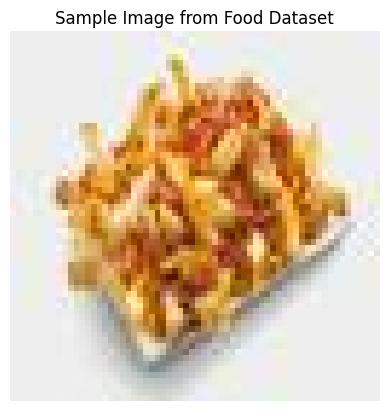

In [3]:
# Display a Sample Image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy())[2])
    plt.title("Sample Image from Food Dataset")
    plt.show()
    break


### The picture quality isn't clear because I reduced the original image size from 128 to 64 when creating a sub-dataset from the Yelp dataset, specifically for testing purposes. with the original images the results could be better but was following some of the reference where 64 is what working well so after multple attempt decided to work like this.

## Discriminator Structure
#### Discriminator (The Detective)

The discriminator in this DCGAN model is designed to classify 64x64 RGB images as real or fake. It follows a convolutional architecture consisting of three Conv2D layers with increasing filters (64, 128), each followed by a LeakyReLU activation function to introduce non-linearity while addressing the vanishing gradient problem. A Flatten layer is used to convert the feature maps into a 1D vector, followed by a Dropout layer to prevent overfitting. Finally, a Dense layer with a sigmoid activation outputs a probability score indicating whether the input image is real or generated.

In [4]:
# Create the Discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()



Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## Generator (The Artist)

The generator creates 64x64 RGB images from random noise (latent vectors of size 100). It uses a Dense layer to reshape the input into a small feature map (4x4x512) and progressively upsamples it through Conv2DTranspose layers with decreasing filters (256, 128, 64, 3). BatchNormalization stabilizes training, and LeakyReLU adds non-linearity. The final layer uses a tanh activation to output normalized RGB images in the range [-1, 1]. This architecture enables the generator to produce realistic images that mimic real data.

In [5]:
# Create the Generator
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()



Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

## Override train_step


In [6]:
# Create GAN Class
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Batch size
        batch_size = tf.shape(real_images)[0]

        # Sample random latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([real_images, generated_images], axis=0)

        # Create labels for real and fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Create "misleading" labels for generator
        misleading_labels = tf.ones((batch_size, 1))

        # Train generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}



### Track Training Progress

In [7]:

# GAN Monitor Callback
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")



# Compile and Train the GAN


In [8]:

# Compile and Train the GAN
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

epochs = 10  # Adjust as needed
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


Epoch 1/10


I0000 00:00:1732492098.470303     111 service.cc:145] XLA service 0x7b0140002520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732492098.470369     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732492098.470375     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1732492098.684063     111 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
I0000 00:00:1732492113.957101     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3377/3377 ━━━━━━━━━━━━━━━━━━━━ 928s 269ms/step - d_loss: 0.6628 - g_loss: 0.7995
Epoch 2/10
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 900s 266ms/step - d_loss: 0.6812 - g_loss: 0.7236
Epoch 3/10
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 899s 266ms/step - d_loss: 0.6885 - g_loss: 0.6856
Epoch 4/10
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 899s 266ms/step - d_loss: 0.6901 - g_loss: 0.6756
Epoch 5/10
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 900s 266ms/step - d_loss: 0.6912 - g_loss: 0.6687
Epoch 6/10
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 899s 266ms/step - d_loss: 0.6898 - g_loss: 0.6745
Epoch 7/10
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 900s 266ms/step - d_loss: 0.6889 - g_loss: 0.6757
Epoch 8/10
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 899s 266ms/step - d_loss: 0.6882 - g_loss: 0.6765
Epoch 9/10
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 899s 266ms/step - d_loss: 0.6860 - g_loss: 0.6806
Epoch 10/10
3377/3377 ━━━━━━━━━━━━━━━━━━━━ 900s 266ms/step - d_loss: 0.6831 - g_loss: 0.6894


In [15]:
# Save the trained GAN model in the default SavedModel format
gan.save("/kaggle/working/gan_final_model.keras")
print("Trained GAN model saved successfully in SavedModel format!")


Trained GAN model saved successfully in SavedModel format!


In [19]:
# Save the trained GAN model in the default SavedModel format
generator.save("/kaggle/working/gene_final_model.keras")
print("Trained Generator model saved successfully in SavedModel format!")


Trained Generator model saved successfully in SavedModel format!


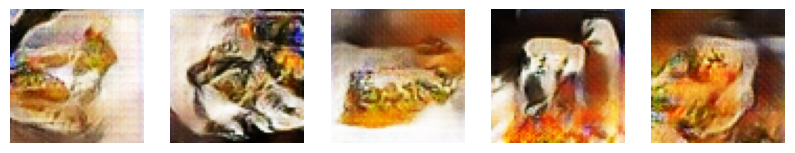

In [17]:
import numpy as np
from tensorflow.keras.utils import array_to_img

# Number of images to generate
num_images = 5

# Generate random latent vectors
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

# Use the generator to create fake images
generated_images = generator(random_latent_vectors)

# Denormalize the images to bring them back to [0, 255] range
generated_images = (generated_images * 255).numpy().astype("uint8")

# Visualize the generated images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(array_to_img(generated_images[i]))
    plt.axis("off")
plt.show()

## Reference of all the learning
- I coundn't get all of it but yes learned as much as possible!!

My part was Till the model building and creating an Gnerator images and tried it for 2 - 5 epoch later on Kundan took over from evaluation and further needed thing



- Github https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/Computer_Vision/DCGAN%20from%20Scratch%20with%20TensorFlow%20-%20Generate%20fake%20Faces%20from%20CelebA%20Dataset/DCGAN_with_Tensorflow_Keras_Celeb_A_Dataset.ipynb
- https://github.com/AarohiSingla/DCGAN-Generating-Fake-Faces-with-DCGAN/blob/main/dcgan.ipynb
- https://keras.io/examples/generative/dcgan_overriding_train_step/#override-trainstep
- https://www.tensorflow.org/tutorials/generative/dcgan
- Research paper : https://arxiv.org/pdf/1511.06434 

# FID Score and Inception Score

In [27]:
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model

In [28]:
# Function to calculate FID
def calculate_fid(real_images, generated_images):
    """
    Calculate the FID (Frechet Inception Distance) between two sets of images.
    Parameters:
        real_images (np.ndarray): Real images with shape (N, H, W, C).
        generated_images (np.ndarray): Generated images with shape (N, H, W, C).
    Returns:
        fid (float): The FID score.
    """
    # Load InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Resize and preprocess real and generated images
    real_images = tf.image.resize(real_images, (299, 299))
    generated_images = tf.image.resize(generated_images, (299, 299))
    real_images = preprocess_input(real_images.numpy())
    generated_images = preprocess_input(generated_images.numpy())

    # Get features
    real_features = model.predict(real_images, verbose=0)
    generated_features = model.predict(generated_images, verbose=0)

    # Calculate mean and covariance
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Function to calculate Inception Score
def calculate_inception_score(generated_images, num_splits=10):
    """
    Calculate the Inception Score for a set of images.
    Parameters:
        generated_images (np.ndarray): Generated images with shape (N, H, W, C).
        num_splits (int): Number of splits for calculating the score.
    Returns:
        mean_score (float): The mean inception score.
        std_score (float): The standard deviation of the inception score.
    """
    # Load InceptionV3 model
    model = InceptionV3(include_top=True, weights='imagenet')
    
    # Preprocess images
    generated_images = tf.image.resize(generated_images, (299, 299))
    generated_images = preprocess_input(generated_images.numpy())

    # Predict probabilities
    preds = model.predict(generated_images, verbose=0)

    # Split predictions
    split_scores = []
    for i in range(num_splits):
        part = preds[i * len(preds) // num_splits: (i + 1) * len(preds) // num_splits]
        py = np.mean(part, axis=0)
        scores = [np.exp(np.sum(p * np.log(p / py))) for p in part]
        split_scores.append(np.mean(scores))

    return np.mean(split_scores), np.std(split_scores)

# Example usage
# Generate fake images
num_images = 100  # Adjust as needed
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = generator(random_latent_vectors)
generated_images = (generated_images * 255).numpy().astype('uint8')

# Load a batch of real images
for real_images in dataset.take(1):
    real_images = real_images

# Calculate FID
fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score}")

# Calculate Inception Score
mean_inception_score, std_inception_score = calculate_inception_score(generated_images)
print(f"Inception Score: {mean_inception_score} ± {std_inception_score}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
FID Score: 603.9203887346616
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Inception Score: 2.914928436279297 ± 0.38768327236175537
